In [75]:
%matplotlib inline

# Assignment 5

**DUE: Sunday December 4, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [76]:
NAME = "Fabrice Kurmann"
STUDENT_ID = "1808546"

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## Question 1: Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past two years and reached an all time high of \$68,789.63 per bitcoin. Since reaching it's high, the price has dropped 75\%. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent Neural Network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

Link to the raw data: [link](https://drive.google.com/file/d/1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b)

In [78]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')

In [79]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [80]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

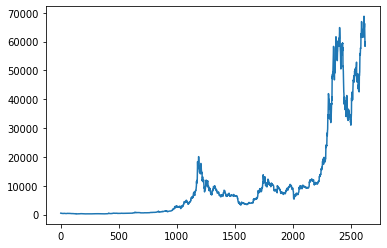

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

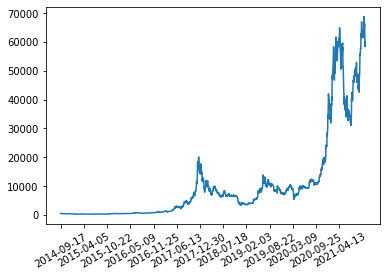

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data Preprocessing (5 points)
In this section you will preprocess the data in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [83]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.

data_high = data.High.values
data_high = data_high.astype(np.float32)

Remove missing values from the data.

In [84]:
# Remove enteries from the data with missing values. 
# The shape of the data after this step shoud be (2618,)

data_high = data_high[~np.isnan(data_high)]
data_high.shape

(2618,)


Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [85]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

data_normalized = scaler.fit_transform(data_high.reshape((-1, 1)))
data_normalized.T

array([[0.00373944, 0.00357446, 0.00315122, ..., 0.8856611 , 0.8477861 ,
        0.86978686]], dtype=float32)

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [86]:
def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        # dataY.append(dataset[i + time_steps])
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

In [87]:
# Choose the number of time steps that the model "looks back"
time_steps = 4

# Produce your dataset based on the number of days the model could look back
X, y = create_dataset(data_normalized, time_steps)

In [88]:
# Check the shape of your dataset; should be (2618-time_steps-1, time_steps) and (2618-time_steps-1,)
print(X.shape, y.shape)

(2611, 6, 1) (2611,)


### Part b) Data Partitioning (5 points)
Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [89]:
# Split into train and test sets.
train_size = int(len(data_normalized) * 0.8)
test_size = len(data_normalized) - train_size
train, test = data_normalized[0: train_size, :], data_normalized[train_size: len(data_normalized), :]
print(len(train), len(test))

X_train, y_train = create_dataset(train, time_steps)
X_test, y_test = create_dataset(test, time_steps)

2094 524


For this dataset, you need to reshape the partitions for the model to be able to process them.

In [90]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# The shape of the training and test data after this step should be ((2618-time_steps-1) * 80%, 1, 4) and ((2618-time_steps-1) * 20%, 1, 4), respectively.
X_train.shape, X_test.shape

((2087, 1, 6), (517, 1, 6))

### Part c) RNN Model (15 points)
In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary. Train the model and plot loss values.

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(LSTM(4, input_shape=(1, time_steps)))
model.add(Dense(1))

loss = 'mean_squared_error'
opt = 'adam'
metrics = 'accuracy'

model.compile(loss = loss, 
              optimizer = opt,
              metrics = metrics)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 4)                 176       
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [92]:
batchsize = 1
epochs =  20

# Fit model - Use 20% validation split
hist = model.fit(X_train, 
                 y_train,
                 epochs = epochs, 
                 batch_size = batchsize,
                 validation_split=0.2)

In [93]:
# Plot the model loss
def plot_losses(hist):
    print('Validation lowest loss:', min(hist.history['loss']))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

plot_losses(hist)

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [94]:
tf.random.set_seed(7)

# # load the dataset
# dataframe = pd.read_csv('BTC-USD.csv', usecols=['High'], engine='python')
# dataset = dataframe.values
# dataset = dataset.astype('float32')

# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

# # split into train and test sets
# train_size = int(len(dataset) * 0.8)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# # reshape into X=t and Y=t+1
# look_back = 6
# X_train, y_train = create_dataset(train, look_back)
# X_test, y_test = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# testX = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [95]:
# Single layer model used for hyperparameter experimentation
time_steps = 6

model1 = Sequential()
model1.add(LSTM(10, input_shape=(1, time_steps)))
model1.add(Dense(1))

loss = 'mean_squared_error'
opt = 'adam'
metrics = 'accuracy'

model1.compile(loss = loss, 
              optimizer = opt,
              metrics = metrics)

# Multi layer model experimented with, did not outperform single layer model

# model1 = Sequential()
# model1.add(LSTM(10, batch_input_shape=(1, time_steps, 1), stateful=True, return_sequences=True))
# model1.add(LSTM(10, batch_input_shape=(1, time_steps, 1), stateful=True))
# model1.add(Dense(1))

# loss = 'mean_squared_error'
# opt = 'adam'
# metrics = 'accuracy'

# model1.compile(loss = loss, 
#               optimizer = opt,
#               metrics = metrics)

model1.summary()

In [96]:
# Fit model - Use 20% validation split
hist = model1.fit(X_train, 
                 y_train,
                 epochs = epochs, 
                 batch_size = batchsize,
                 validation_split=0.2)

Epoch 1/20
1669/1669 [==============================] - 5s 2ms/step - loss: 3.1761e-04 - accuracy: 5.9916e-04 - val_loss: 8.3016e-05 - val_accuracy: 0.0000e+00
Epoch 2/20
1669/1669 [==============================] - 4s 2ms/step - loss: 5.3307e-05 - accuracy: 5.9916e-04 - val_loss: 1.2605e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
1669/1669 [==============================] - 4s 2ms/step - loss: 4.6455e-05 - accuracy: 5.9916e-04 - val_loss: 6.9487e-05 - val_accuracy: 0.0000e+00
Epoch 4/20
1669/1669 [==============================] - 4s 2ms/step - loss: 4.1131e-05 - accuracy: 5.9916e-04 - val_loss: 7.1207e-05 - val_accuracy: 0.0000e+00
Epoch 5/20
1669/1669 [==============================] - 4s 2ms/step - loss: 3.9913e-05 - accuracy: 5.9916e-04 - val_loss: 4.9275e-05 - val_accuracy: 0.0000e+00
Epoch 6/20
1669/1669 [==============================] - 3s 2ms/step - loss: 3.6622e-05 - accuracy: 5.9916e-04 - val_loss: 7.1890e-05 - val_accuracy: 0.0000e+00
Epoch 7/20
1669/1669 [==================

Validation lowest loss: 2.0314597350079566e-05


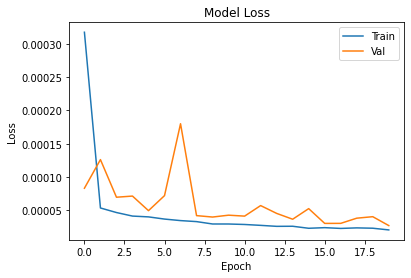

In [97]:
# Plot the model loss
plot_losses(hist)

### Part e) Looking at the Predictions (10 points)
Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help?

**Note:** Your model is trained on normalized data. In order to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [98]:
# make predictions
trainPredict = model1.predict(X_train, batch_size=batchsize)
model.reset_states()
testPredict = model1.predict(X_test, batch_size=batchsize)

testPredict[:10]

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

testPredict[:10]

517/517 [==============================] - 1s 1ms/step


array([[9539.308],
       [9500.462],
       [9453.803],
       [9402.469],
       [9395.006],
       [9559.135],
       [9632.17 ],
       [9672.603],
       [9456.082],
       [9338.284]], dtype=float32)

In [99]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score:', np.round(trainScore, 4), 'RMSE')
testScore = np.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: ', np.round(testScore, 4), 'RMSE')

Train Score: 322.9144 RMSE
Test Score:  8481.1909 RMSE


In [100]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_normalized)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_steps: len(trainPredict) + time_steps, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_normalized)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + time_steps*2 + 1: len(data_normalized) - 1, :] = testPredict

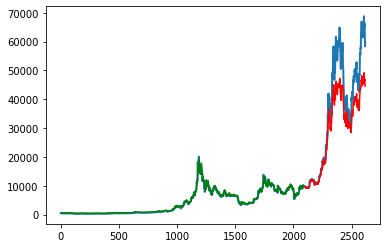

In [101]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_normalized), linewidth=2)
plt.plot(trainPredictPlot, 'g')
plt.plot(testPredictPlot, 'r')
plt.show()

Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help?

My original simple model from part C had a lowest validation loss of 1.95e-05 and achieved a train RMSE or 293 and test RMSE of 9449 with 4 look back steps in 20 epochs of training. 

To attempt to improve this I began by using a modified LTSM layer where I experimented with the ideal number or neurons, trying both 2 and 4 in this layer; 2 neurons performed worse, with around 11500 RMSE, 10 neurons perfomred best with a RMSE or 6300, while taking it up to 20 started performing worse again. 

I then focused on the number of lookback days, trying 2, 4, 6, and 10. Only 2 lookback days caused a very inaccurate prediction while 6 performed best here with a RMSE of only 1600 compared to 6300 for 4 lookback days. Taking this parameter up to 8 hurt accuracy again, resulting in RMSE of 2800. 

## Question 2: Reuters Topic Classification
---
We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```



### Part a) Processing the Data (5 points)
Load the data simply from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data.
You also need to follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

Print 5 examples of news along with their class label. 

In [102]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import numpy as np
import string
import textwrap
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model

# Load data
max_sequence_len = 200 
(X, y), (_, _) = reuters.load_data(maxlen=max_sequence_len)

In [103]:
# Map words to dictionary
word_dict = reuters.get_word_index()
for i in range(50):
  for key, value in word_dict.items(): 
    if value == i:
        print('(', key, ',', value, ')', sep = '', end = ',')

print()
print()
print(len(word_dict))

(the,1),(of,2),(to,3),(in,4),(said,5),(and,6),(a,7),(mln,8),(3,9),(for,10),(vs,11),(dlrs,12),(it,13),(reuter,14),(000,15),(1,16),(pct,17),(on,18),(from,19),(is,20),(that,21),(its,22),(cts,23),(by,24),(at,25),(year,26),(be,27),(with,28),(2,29),(will,30),(was,31),(billion,32),(he,33),(u,34),(s,35),(net,36),(has,37),(would,38),(an,39),(as,40),(5,41),(not,42),(loss,43),(4,44),(1986,45),(company,46),(which,47),(but,48),(this,49),

30979


In [104]:
# Preprocess data by adding tags
word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3

# Inspect the vocablulary
vocab_size = len(word_dict.keys())
print('Number of words in vocabulary: ', vocab_size)
print()

for i in range(50):
  for key, value in word_dict.items(): 
    if value == i:
        print('(', key, ',', value, ')', sep = '', end = ',')

Number of words in vocabulary:  30983

(<PAD>,0),(<START>,1),(<UNK>,2),(<UNUSED>,3),(the,4),(of,5),(to,6),(in,7),(said,8),(and,9),(a,10),(mln,11),(3,12),(for,13),(vs,14),(dlrs,15),(it,16),(reuter,17),(000,18),(1,19),(pct,20),(on,21),(from,22),(is,23),(that,24),(its,25),(cts,26),(by,27),(at,28),(year,29),(be,30),(with,31),(2,32),(will,33),(was,34),(billion,35),(he,36),(u,37),(s,38),(net,39),(has,40),(would,41),(an,42),(as,43),(5,44),(not,45),(loss,46),(4,47),(1986,48),(company,49),

In [105]:
# Needed to decode training data into readable text
inverse_word_dict = {value:key for key,value in word_dict.items()}

print(X[-1])
X = pad_sequences(X, maxlen=max_sequence_len)
print(X[-1])

[1, 1682, 149, 56, 7284, 38, 8, 25, 211, 5, 56, 3585, 427, 3172, 149, 33, 45, 1575, 4, 100, 65, 9, 249, 881, 16, 6870, 58, 1817, 1682, 385, 3585, 50, 1043, 42, 305, 147, 20, 7, 4, 2033, 149, 56, 7400, 38, 727, 3513, 10610, 2986, 4886, 249, 9, 3264, 656, 2355, 6, 42, 1808, 81, 56, 3953, 304, 13, 4774, 11, 15, 21, 93, 19, 7, 10, 241, 6, 6717, 4, 636, 1682, 8, 16, 33, 2264, 25, 12742, 249, 304, 4, 1709, 12742, 9219, 249, 926, 9, 4, 27668, 4138, 21, 23794, 1039, 962, 691, 881, 7, 4565, 9, 13928, 2067, 598, 17, 12]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0    

In [106]:
# Functions to encode and decode stories
def encode_story(story, word_dict, maxlen):
  encoded_story = []
  for raw_word in story.split(' '):
    word = raw_word.strip().strip(string.punctuation).lower()
    if word is '' or word is '\n':
      continue
    try:
      encoded_story.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, review not encoded.')
      continue
  return pad_sequences(np.array(encoded_story).reshape(1,-1), maxlen=maxlen)

def decode_story(encoded_story, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_story:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-106-e03ac203afdd>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if word is '' or word is '\n':
<ipython-input-106-e03ac203afdd>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if word is '' or word is '\n':


In [107]:
print(decode_story(X[-1], inverse_word_dict), end='\n\n')

print('Sentiment: ', y[-1])

<START> csr ltd lt csra s said its sale of lt delhi petroleum pty ltd will not affect the other oil and gas interests it
manages or operates csr sold delhi which holds an average 25 pct in the santos ltd lt stos s led cooper eromanga basin
onshore gas and liquids joint ventures to an exxon corp lt xon unit for 985 mln dlrs on april 1 in a statement to
clarify the position csr said it will retain its roma gas unit the associated roma brisbane gas pipeline and the bula
oilfield on seram indonesia plus exploration interests in queensland and hainan island china reuter 3

Sentiment:  4


### Part b) Data Partitioning (5 points)

Split data into train and test sets. Please use 80% for training and 20% for testing. Note that we want to have the same distribution of labels in the training and test set, so you can use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [108]:
import numpy as np
from sklearn.model_selection import train_test_split
# Split into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Part c) Simple RNN Model (15 points)

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your accuracy metric.

Compile your model and display the summary:

In [109]:
# Build your model
input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 128)(input_layer)

x = LSTM(64)(x) 

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.8)(x)

x = Dense(46, activation='softmax')(x)

model = Model(input_layer, x)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = 'adam'
metrics = ['accuracy']

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 128)          3965824   
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0   

In [110]:
batchsize = 256
epochs =  10

# Fit model
hist = model.fit(X_train, y_train.reshape(-1,1), batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


18/18 [==============================] - 15s 693ms/step - loss: 3.7636 - accuracy: 0.0554 - val_loss: 3.3925 - val_accuracy: 0.3922
Epoch 2/10
18/18 [==============================] - 12s 657ms/step - loss: 3.4391 - accuracy: 0.1283 - val_loss: 2.8780 - val_accuracy: 0.5168
Epoch 3/10
18/18 [==============================] - 12s 655ms/step - loss: 2.9338 - accuracy: 0.2953 - val_loss: 2.0822 - val_accuracy: 0.5265
Epoch 4/10
18/18 [==============================] - 12s 658ms/step - loss: 2.5563 - accuracy: 0.4103 - val_loss: 2.0877 - val_accuracy: 0.5424
Epoch 5/10
18/18 [==============================] - 12s 659ms/step - loss: 2.3062 - accuracy: 0.4662 - val_loss: 1.7429 - val_accuracy: 0.5963
Epoch 6/10
18/18 [==============================] - 12s 658ms/step - loss: 2.1036 - accuracy: 0.4958 - val_loss: 1.6393 - val_accuracy: 0.5883
Epoch 7/10
18/18 [==============================] - 12s 661ms/step - loss: 1.9884 - accuracy: 0.5172 - val_loss: 1.6344 - val_accuracy: 0.6175
Epoch 8/10

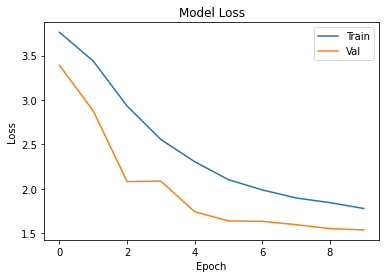

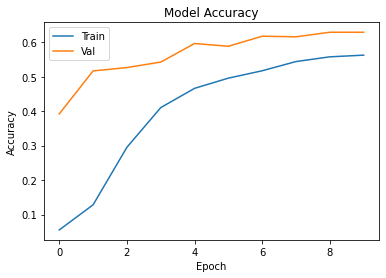

In [111]:
# Plot the model loss and accuracy on training and validation sets

def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

plot_losses(hist)
plot_accuracies(hist)
plt.show()

### Part d) More Advanced RNN Model (15 points)
In this part, you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [112]:
# Build your model
input_layer = Input(shape=(max_sequence_len))
x = Embedding(vocab_size, 128)(input_layer)
x = LSTM(64)(x) 

x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(46, activation='softmax')(x)
model1 = Model(input_layer, x)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = 'adam'
metrics = ['accuracy']

model1.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 200, 128)          3965824   
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 46)                2990      
                                                                 
Total params: 4,022,382
Trainable params: 4,022,382
Non-tra

In [113]:
batchsize = 256
epochs =  10

# Fit model
hist = model1.fit(X, y.reshape(-1,1), batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/10
23/23 [==============================] - 17s 667ms/step - loss: 3.4636 - accuracy: 0.3214 - val_loss: 2.4929 - val_accuracy: 0.4018
Epoch 2/10
23/23 [==============================] - 15s 661ms/step - loss: 2.5839 - accuracy: 0.3567 - val_loss: 2.2059 - val_accuracy: 0.4018
Epoch 3/10
23/23 [==============================] - 15s 643ms/step - loss: 2.1378 - accuracy: 0.4726 - val_loss: 1.8046 - val_accuracy: 0.5494
Epoch 4/10
23/23 [==============================] - 15s 646ms/step - loss: 1.7501 - accuracy: 0.5680 - val_loss: 1.6264 - val_accuracy: 0.5685
Epoch 5/10
23/23 [==============================] - 15s 644ms/step - loss: 1.5547 - accuracy: 0.6136 - val_loss: 1.5498 - val_accuracy: 0.6038
Epoch 6/10
23/23 [==============================] - 15s 648ms/step - loss: 1.4750 - accuracy: 0.6403 - val_loss: 1.5502 - val_accuracy: 0.6102
Epoch 7/10
23/23 [==============================] - 15s 650ms/step - loss: 1.3972 - accuracy: 0.6405 - val_loss: 1.5151 - val_accuracy: 0.6215

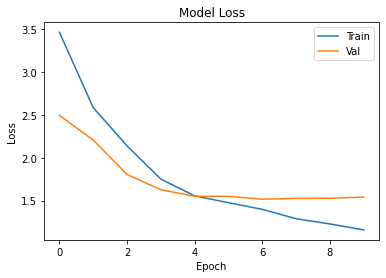

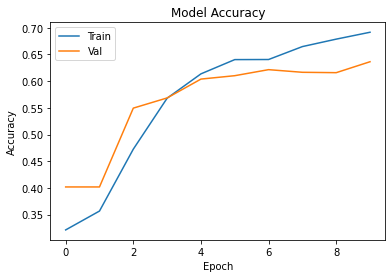

In [114]:
# Plot the model loss and accuracy
plot_losses(hist)
plot_accuracies(hist)
plt.show()

### Part e) Looking at the Predictions (10 points)

Now, Using the final (best) model you trained, show your model's performance on the test set.
Calculate and display the prediction accuracy for all of the 46 different classes. 

In [115]:
# Make predictions
trainPredict = model1.predict(X_train)
testPredict = model1.predict(X_test)

# Scale predictions to integers
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)


# Find model's prediction
testPredictFinal = [];
for x in testPredict:
    x = np.argmax(x)
    testPredictFinal.append(x)

# Create with separate index for all classes
classArray = [0 for i in range(46)] 
classArrayPred = [0 for i in range(46)] 
accuracyArray = [0 for i in range(46)] 

# Fill class arrays according to test values and predicted values
for i in range(len(y_test)):
    classArray[y_test[i]] += 1;
    classArrayPred[testPredictFinal[i]] += 1;

# Find each class's accuracy between prediction and y_test
for i in range(46):
    if (classArray[i] == 0 and classArrayPred[i] == 0):
        accuracyArray[i] = 0
    elif (classArray[i] == 0):
        accuracyArray[i] = abs(classArray[i] - classArrayPred[i]) / classArrayPred[i]
    else:
        accuracyArray[i] = abs(classArray[i] - classArrayPred[i]) / classArray[i]
    
    if (accuracyArray[i] > 1):
        accuracyArray[i] = 1/accuracyArray[i]

# Print accuracy array
print('Accuracies across classes 1 thru 46:')
print(accuracyArray)

45/45 [==============================] - 1s 31ms/step
[1.0, 0.625, 1.0, 0.016181229773462782, 0.07384615384615385, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33962264150943394, 1.0, 1.0, 1.0, 1.0, 0.9565217391304348, 1.0, 1.0, 0.9, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 1.0, 1.0, 1.0]
